# Исследование надёжности заёмщиков

**Описание данных**

- *children —* количество детей в семье
- *days_employed* — общий трудовой стаж в днях
- *dob_years* — возраст клиента в годах
- *education* — уровень образования клиента
- *education_id* — идентификатор уровня образования
- *family_status* — семейное положение
- *family_status_id* — идентификатор семейного положения
- *gender* — пол клиента
- *income_type* — тип занятости
- *debt* — имел ли задолженность по возврату кредитов
- *total_income* — ежемесячный доход
- *purpose* — цель получения кредита

1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропусков](#nan)
    * [Замена типа данных](#datatype)
    * [Обработка дубликатов](#duplicates)
    * [Лемматизация + Категоризация](#lemmas)
3. [Ответы на вопросы исследования](#answers)
4. [Общий вывод](#summary)
5. [Чек-лист готовности](#check)  

<a id="start"></a>
## Шаг 1. Откройте файл с данными и изучите общую информацию 

In [52]:
import pandas as pd
import numpy as np 
import numpy as np
import matplotlib.pyplot as plt

from pymystem3 import Mystem
from collections import Counter

In [53]:
data = pd.read_csv('/datasets/data.csv')
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


При первом взгляде сразу бросается в глаза наличие некорректных значений в столбце `days_employed`, разный регистр в данных столбца `education`, неудобный для восприятия денежных сумм формат в столбце `total_income`. 

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Здесь видно, что в данных есть пропущенные значения, будет необходимо с ними разобраться. 

In [55]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

На всякий случай проверили, корректно ли записаны названия столбцов, чтобы дальше можно было их спокойно использовать.

**Вывод**

При поверхностном рассмотрении обнаружены некоторые проблемы в данных, далее посмотрим на них подробнее.

In [56]:
# Можно осмотреть статистики, а также уникальные значения по категориальным признакам

display(data.describe()) # сразу видно аномалии

for col in data.columns:
    
    if data[col].dtype == "object":
    
        print(col)
        print(data[col].unique())
        print()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


education
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']

family_status
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']

gender
['F' 'M' 'XNA']

income_type
['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']

purpose
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операци

Видим, что минимум по детям/возрасту/стажу выглядит странно, как и максимум по детям/стажу. Помимо этого, есть аномалии по полу/регистру.

<a id="preprocessing"></a>
## Шаг 2. Предобработка данных

<a id="nan"></a>
### Обработка пропусков

Посчитаем, сколько значений пропущено:

In [57]:
data.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Вот так они выглядят в таблице:

In [58]:
data.loc[data.isnull().any(axis=1)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


При самом первом рассмотрении таблицы мы заметили, что в `days_employed` есть некорректные значения, а именно отрицательные или слишком большие (например 359219/365 это почти 1000 лет стажа!). Выглядит забавно, но такие данные нам явно все испортят.
Появилось предположение, что отрицательные значения на самом деле нормальные, просто могли попортиться из-за какой-то технической ошибки. В следующих шагах мы это исправим, поменяв знак. А вот те, что больше нуля, все же являются неадекватными и от них скорее всего придется каким-то образом избавляться, заменив на более адекватные. Проверим:

In [59]:
data.loc[data['days_employed'] > 0].sort_values('total_income')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
14585,0,359219.059341,57,среднее,1,женат / замужем,0,F,пенсионер,1,20667.263793,недвижимость
13006,0,369708.589113,37,среднее,1,гражданский брак,1,M,пенсионер,0,21205.280566,заняться высшим образованием
1598,0,359726.104207,68,среднее,1,гражданский брак,1,M,пенсионер,0,21695.101789,на проведение свадьбы
14276,0,346602.453782,61,среднее,1,женат / замужем,0,F,пенсионер,0,21895.614355,недвижимость
10881,0,347356.519176,71,среднее,1,женат / замужем,0,M,пенсионер,0,22472.755205,операции со своей недвижимостью
...,...,...,...,...,...,...,...,...,...,...,...,...
1409,0,334060.678873,65,среднее,1,женат / замужем,0,F,пенсионер,0,644077.836518,образование
1131,0,378612.272926,49,среднее,1,гражданский брак,1,M,пенсионер,0,681300.590458,на проведение свадьбы
10725,0,373012.754501,64,высшее,0,гражданский брак,1,F,пенсионер,0,694150.890876,покупка жилья для семьи
6084,0,351717.389895,65,высшее,0,женат / замужем,0,M,пенсионер,0,708927.197617,операции с коммерческой недвижимостью


Действительно, все положительные значения не соответствуют действительности. Возможно это так же произошло в результате какой-то технической ошибки при сборе данных.

Бороться с некорректными значениями в `days_employed` будем следующим образом:
- У отрицательных значений поменяем знак,
- Недекватные значения и пропущенные значения (так как их достаточно много) заменим на медианное в зависимости от возвраста. 

Так как возраст нам понадобится, посмотрим, какие значения у нас имеются и отсортируем по возрастанию:

In [60]:
ages = data['dob_years'].unique()
ages.sort()
ages

array([ 0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

Начнем с неадекватных и пропущенных значений. Чтобы заменить их на медианное, для начала нужно выбрать данные, на которые мы будем опираться при расчетах. Сохраним их во временную переменную `tmp`.

In [61]:
tmp = data[data['days_employed'] < 0] #выше мы предположили, что отрицательные значения на самом деле нормальные, их и используем
tmp = tmp[tmp['dob_years'] > 0] #нулевой возраст нас не интересует
tmp.loc[:,'days_employed'] = tmp['days_employed'].abs() #меняем знак
tmp.sort_values('days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
17437,1,24.141633,31,среднее,1,женат / замужем,0,F,сотрудник,1,166952.415427,высшее образование
8336,0,24.240695,32,высшее,0,Не женат / не замужем,4,M,сотрудник,0,124115.373655,получение дополнительного образования
6157,2,30.195337,47,среднее,1,гражданский брак,1,M,компаньон,0,231461.185606,свадьба
9683,0,33.520665,43,среднее,1,Не женат / не замужем,4,M,сотрудник,1,128555.897209,приобретение автомобиля
2127,1,34.701045,31,высшее,0,женат / замужем,0,F,компаньон,0,90557.994311,получение образования
...,...,...,...,...,...,...,...,...,...,...,...,...
16825,0,16119.687737,64,среднее,1,женат / замужем,0,F,сотрудник,0,91527.685995,покупка жилой недвижимости
17838,0,16264.699501,59,среднее,1,женат / замужем,0,F,сотрудник,0,51238.967133,на покупку автомобиля
7329,0,16593.472817,60,высшее,0,женат / замужем,0,F,сотрудник,0,124697.846781,заняться высшим образованием
4299,0,17615.563266,61,среднее,1,женат / замужем,0,F,компаньон,0,122560.741753,покупка жилья


Получили вполне адекватные данные, на основе которых сможем рассчитать медианное значение стажа в зависимости от возраста.

Добавим новый столбец, в котором рассчитаем сколько дней человек работал в год (поделим стаж на возраст):

In [62]:
tmp['days_per_year'] = tmp['days_employed'] / tmp['dob_years']
tmp.sort_values('days_per_year')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_per_year
6157,2,30.195337,47,среднее,1,гражданский брак,1,M,компаньон,0,231461.185606,свадьба,0.642454
8336,0,24.240695,32,высшее,0,Не женат / не замужем,4,M,сотрудник,0,124115.373655,получение дополнительного образования,0.757522
17437,1,24.141633,31,среднее,1,женат / замужем,0,F,сотрудник,1,166952.415427,высшее образование,0.778762
9683,0,33.520665,43,среднее,1,Не женат / не замужем,4,M,сотрудник,1,128555.897209,приобретение автомобиля,0.779550
7964,0,47.109840,49,высшее,0,женат / замужем,0,F,сотрудник,0,197545.271278,на покупку подержанного автомобиля,0.961425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17838,0,16264.699501,59,среднее,1,женат / замужем,0,F,сотрудник,0,51238.967133,на покупку автомобиля,275.672873
7329,0,16593.472817,60,высшее,0,женат / замужем,0,F,сотрудник,0,124697.846781,заняться высшим образованием,276.557880
5708,0,13210.485012,47,среднее,1,женат / замужем,0,F,сотрудник,0,144845.875361,покупка недвижимости,281.074149
4299,0,17615.563266,61,среднее,1,женат / замужем,0,F,компаньон,0,122560.741753,покупка жилья,288.779726


Теперь посчитаем медиану. Её мы будем использовать для замены неадекватных и пропущенных значений.

In [63]:
med_work_days_annual = tmp['days_per_year'].median()
data.loc[data['days_employed'].isna(),'days_employed'] = med_work_days_annual * data[data['days_employed'].isna()]['dob_years']
data.loc[data['days_employed'] > 0,'days_employed'] = med_work_days_annual * data[data['days_employed'] > 0]['dob_years']

Также параллельно разберемся с пропущенными значениями в `total_income`. Заменим их медианным значением в зависимости от типа занятости:

In [64]:
median_dict = data[['income_type', 'total_income']].groupby('income_type').median().to_dict()['total_income']

def define_total_income(row):
    if pd.isna(row['total_income']):
        return median_dict[row['income_type']]
    return row['total_income']

In [65]:
data['total_income'] = data.apply(define_total_income, axis=1)

In [66]:
data.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропущенных значений больше нет.

Теперь поменяем знак у отрицательных значений в основном датасете и выведем его, отсортировав по `days_employed`:

In [67]:
data.loc[:,'days_employed'] = data['days_employed'].abs()
data.sort_values('days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
14514,0,0.000000,0,среднее,1,вдовец / вдова,2,F,пенсионер,0,87215.410371,заняться высшим образованием
4064,1,0.000000,0,среднее,1,гражданский брак,1,M,компаньон,0,172357.950966,ремонт жилью
6670,0,0.000000,0,Высшее,0,в разводе,3,F,пенсионер,0,118514.486412,покупка жилой недвижимости
5014,0,0.000000,0,среднее,1,женат / замужем,0,F,компаньон,0,172357.950966,покупка недвижимости
20577,0,0.000000,0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,129788.762899,недвижимость
...,...,...,...,...,...,...,...,...,...,...,...,...
16825,0,16119.687737,64,среднее,1,женат / замужем,0,F,сотрудник,0,91527.685995,покупка жилой недвижимости
17838,0,16264.699501,59,среднее,1,женат / замужем,0,F,сотрудник,0,51238.967133,на покупку автомобиля
7329,0,16593.472817,60,высшее,0,женат / замужем,0,F,сотрудник,0,124697.846781,заняться высшим образованием
4299,0,17615.563266,61,среднее,1,женат / замужем,0,F,компаньон,0,122560.741753,покупка жилья


Теперь разберемся с нулевыми значениями возвраста. Скорее всего это какая-то ошибка. Посмотрим, какой процент от общего количества данных составляют такие строки, и удалим их, если их меньше одного процента.

In [68]:
data[data['dob_years'] == 0]['dob_years'].count() / data['dob_years'].count() * 100

0.4692218350754936

In [69]:
data = data[data['dob_years'] != 0]
data[data['dob_years'] == 0]['dob_years'].count()

0

In [70]:
data.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Еще раз проверили пропущенные значения. Тут все хорошо. 

Для ответа на один из вопросов исследования нам понадобятся сведения о детях. Посмотрим, какие есть значения в этом столбце, и сколько их:

In [71]:
data['children'].value_counts()

 0     14080
 1      4802
 2      2042
 3       328
 20       75
-1        47
 4        41
 5         9
Name: children, dtype: int64

Итак, по порядку:
- 47 отрицательных значений, пусть снова виновата некая техническая ошибка, вернем таких детей в нормальное состояние, поменяв знак; в результате они добавятся к записям с количеством детей 1
- 75 людей с 20 детьми выглядит слегка неправдоподобно (даже если допустить, что у кого-то так и есть, то это точно не 75); чтобы понять, как действовать дальше, посмотрим, как много людей с количеством детей 20, у которых есть долг (чтобы оценить, как сильно они влияют на общую картину)

In [72]:
data.loc[:,'children'] = data['children'].abs()
data['children'].value_counts()
data[(data['children'] == 20) & (data['debt'] == 1)]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
1074,20,3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования
10782,20,1044.201789,34,Среднее,1,в разводе,3,M,сотрудник,1,144544.530170,строительство собственной недвижимости
12319,20,507.160088,50,Среднее,1,гражданский брак,1,M,компаньон,1,169780.898628,на проведение свадьбы
12534,20,579.038062,48,среднее,1,гражданский брак,1,F,сотрудник,1,125518.059419,на проведение свадьбы
18890,20,904.259293,37,среднее,1,женат / замужем,0,F,компаньон,1,212811.568585,на покупку подержанного автомобиля
20038,20,782.499396,32,среднее,1,Не женат / не замужем,4,M,сотрудник,1,117758.551168,покупка коммерческой недвижимости
20355,20,2695.079206,45,среднее,1,гражданский брак,1,M,сотрудник,1,177922.630435,на проведение свадьбы
21008,20,1240.257910,40,среднее,1,женат / замужем,0,F,сотрудник,1,133524.010303,свой автомобиль


Всего 8 записей, копейки относительно всего набора данных.

Скорее всего число 20 получилось в результате случайной опечатки. Мне видится такая картинка: типичная работница банка с большим нежеланием работать нелюбимую работу и традиционными длинными ноготочками набирает на нампаде количество детей 2, и в то время как ноготочек нажал на 2, палец нажал на 0. В результате мы теперь имеем 75 людей с 20 детьми. Кажется, кому-то стоит делать ноготочки немного покороче :)

Будем считать, что 20 на самом деле 2, сделаем замену:

In [73]:
data.loc[data['children']== 20,'children'] = 2
data['children'].value_counts()

0    14080
1     4849
2     2117
3      328
4       41
5        9
Name: children, dtype: int64

**Вывод**

Разобрались с пропусками и некорректными значениями в `days_employed`, пропусками в `total_income`, некорректными значениями в `children`

<a id="datatype"></a>
### Замена типа данных

Заменим тип данных столбца `days_employed` и `total_income` на целочисленный. Так будет значительно проще воспринимать данные. К тому же точность до копейки в столбце с заработком для наших целей не нужна. 

In [74]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21424 entries, 0 to 21524
Data columns (total 12 columns):
children            21424 non-null int64
days_employed       21424 non-null int64
dob_years           21424 non-null int64
education           21424 non-null object
education_id        21424 non-null int64
family_status       21424 non-null object
family_status_id    21424 non-null int64
gender              21424 non-null object
income_type         21424 non-null object
debt                21424 non-null int64
total_income        21424 non-null int64
purpose             21424 non-null object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


<a id="duplicates"></a>
### Обработка дубликатов

Подсчитаем количество полных дубликатов, удалим их при наличии, приведем в порядок индексы:

In [75]:
data.duplicated().sum()

54

In [76]:
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

Теперь разберемся с неявными дубликатами в строковых столбцах. Начнем с `education`:

In [77]:
data['education'].value_counts()

среднее                13646
высшее                  4678
СРЕДНЕЕ                  770
Среднее                  708
неоконченное высшее      666
ВЫСШЕЕ                   272
Высшее                   266
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Приведем все к единообразному виду (нижний регистр):

In [78]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15124
высшее                  5216
неоконченное высшее      742
начальное                282
ученая степень             6
Name: education, dtype: int64

Аналогично поступим со столбцами `family_status` и `income_type` (проверяем, переводим в нижний регистр):

In [79]:
data['family_status'].value_counts()

женат / замужем          12295
гражданский брак          4142
Не женат / не замужем     2794
в разводе                 1185
вдовец / вдова             954
Name: family_status, dtype: int64

In [80]:
data['family_status'] = data['family_status'].str.lower()
data['family_status'].value_counts()

женат / замужем          12295
гражданский брак          4142
не женат / не замужем     2794
в разводе                 1185
вдовец / вдова             954
Name: family_status, dtype: int64

In [81]:
data['income_type'].value_counts()

сотрудник          11036
компаньон           5060
пенсионер           3817
госслужащий         1451
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

**Вывод**

Полные дубликаты удалены, неявные — исправлены.

Образовались новые дубликаты. Удаляем:

In [82]:
data.duplicated().sum()

17

In [83]:
data = data.drop_duplicates().reset_index(drop = True)
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,2316,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21348,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21349,0,2928,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21350,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21351,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


Посчитали, сколько каких вариантов пола в датасете. Невалидный нашелся только 1 (вероятнее всего человек просто не указал пол). Пробуем посмотреть на эту запись поближе. Так как никак определить пол у нас не получится, эту строку будет проще просто удалить.

In [84]:
data['gender'].value_counts()

F      14102
M       7250
XNA        1
Name: gender, dtype: int64

In [85]:
data[data['gender']=='XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10632,0,2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


In [86]:
data = data[data['gender']!='XNA']
data['gender'].value_counts()

F    14102
M     7250
Name: gender, dtype: int64

<a id="lemmas"></a>
### Лемматизация + Категоризация

Посмотрим, какие уникальные значения встречаются в столбце с целью кредита, подсчитаем их количество:

In [87]:
data['purpose'].value_counts()

свадьба                                   786
на проведение свадьбы                     764
сыграть свадьбу                           760
операции с недвижимостью                  672
покупка коммерческой недвижимости         658
покупка жилья для сдачи                   649
операции с коммерческой недвижимостью     648
операции с жильем                         646
покупка жилья                             640
жилье                                     640
покупка жилья для семьи                   637
строительство собственной недвижимости    633
недвижимость                              629
операции со своей недвижимостью           627
строительство жилой недвижимости          621
строительство недвижимости                619
покупка своего жилья                      619
покупка недвижимости                      617
ремонт жилью                              605
покупка жилой недвижимости                603
на покупку своего автомобиля              502
заняться высшим образованием      

Чтобы определить, на какие категории разбить цели кредита, выведем все леммы в порядке убывания встречаемости:

In [88]:
m = Mystem()

list_of_lemmas = []
for i in data['purpose']:
    lemma = m.lemmatize(i)
    list_of_lemmas.extend(lemma)
print(Counter(list_of_lemmas))

Counter({' ': 33434, '\n': 21352, 'недвижимость': 6327, 'покупка': 5869, 'жилье': 4436, 'автомобиль': 4284, 'образование': 3995, 'с': 2904, 'операция': 2593, 'свадьба': 2310, 'свой': 2223, 'на': 2210, 'строительство': 1873, 'высокий': 1366, 'получение': 1309, 'коммерческий': 1306, 'для': 1286, 'жилой': 1224, 'сделка': 938, 'дополнительный': 902, 'заниматься': 900, 'проведение': 764, 'сыграть': 760, 'сдача': 649, 'семья': 637, 'собственный': 633, 'со': 627, 'ремонт': 605, 'подержанный': 484, 'подержать': 478, 'приобретение': 459, 'профильный': 435})


Выделим из этого списка наиболее популярные цели: недвижимость (жилье включим туда же), автомобиль, образование, свадьба. Присвоим каждой записи категорию, добавим новый столбец в таблицу:

In [89]:
def define_purpose_category(row):
    purpose_lemma = m.lemmatize(row['purpose'])
    if 'свадьба' in purpose_lemma:
        return 'свадьба'
    if 'автомобиль' in purpose_lemma:
        return 'автомобиль'
    if 'образование' in purpose_lemma:
        return 'образование'
    if any(item in purpose_lemma for item in ['жилье', 'недвижимость']):
        return 'недвижимость'

In [90]:
data['purpose_category'] = data.apply(define_purpose_category, axis=1)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,2316,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21348,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,недвижимость
21349,0,2928,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,автомобиль
21350,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,недвижимость
21351,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,автомобиль


<a id="answers"></a>
## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [91]:
have_children = len(data.loc[data['children'] > 0])
no_children = len(data.loc[data['children'] == 0])
have_children_no_debt = len(data.loc[(data['children'] > 0) & (data['debt'] == 0)])
no_children_no_debt = len(data.loc[(data['children'] == 0) & (data['debt'] == 0)])
have_children_ratio = have_children_no_debt / have_children
no_children_ratio = no_children_no_debt / no_children

print('Процент людей, возвращающих кредит в срок, от числа людей с детьми:', "{:.1%}".format(have_children_ratio)) 
print('Процент людей, возвращающих кредит в срок, от числа людей без детей:', "{:.1%}".format(no_children_ratio))

Процент людей, возвращающих кредит в срок, от числа людей с детьми: 90.8%
Процент людей, возвращающих кредит в срок, от числа людей без детей: 92.5%


**Вывод**

Разница меньше двух процентов выглядит незначительной, но можно предположить, что люди без детей менее склонны к задолженностям по кредиту.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [92]:
#напишем функцию, с помощью которой будем рассчитывать процент для следующих трех случаев
def calc_ratio(column, value):
    total = len(data.loc[data[column] == value])
    no_debt = len(data.loc[(data[column] == value) & (data['debt'] == 0)])
    return no_debt / total

In [93]:
column = 'family_status'
statuses = data[column].drop_duplicates().to_list()
for status in statuses:
    ratio = calc_ratio(column, status)
    print('Процент людей, возвращающих кредит в срок, от числа людей в статусе "{}": {:.2%}'.format(status, ratio)) 

Процент людей, возвращающих кредит в срок, от числа людей в статусе "женат / замужем": 92.46%
Процент людей, возвращающих кредит в срок, от числа людей в статусе "гражданский брак": 90.65%
Процент людей, возвращающих кредит в срок, от числа людей в статусе "вдовец / вдова": 93.50%
Процент людей, возвращающих кредит в срок, от числа людей в статусе "в разводе": 92.83%
Процент людей, возвращающих кредит в срок, от числа людей в статусе "не женат / не замужем": 90.23%


**Вывод**

Можно предположить, что люди, состоящие или когда-либо состоявшие в узаконенных отношениях, менее склонны к задолженностям по кредиту.

- Как разные цели кредита влияют на его возврат в срок?

In [94]:
column = 'purpose_category'
statuses = data[column].drop_duplicates().to_list()
for status in statuses:
    ratio = calc_ratio(column, status)
    print('Процент людей, возвращающих кредит в срок, от числа людей, берущих кредит для цели "{}": {:.2%}'.format(status, ratio))

Процент людей, возвращающих кредит в срок, от числа людей, берущих кредит для цели "недвижимость": 92.76%
Процент людей, возвращающих кредит в срок, от числа людей, берущих кредит для цели "автомобиль": 90.66%
Процент людей, возвращающих кредит в срок, от числа людей, берущих кредит для цели "образование": 90.74%
Процент людей, возвращающих кредит в срок, от числа людей, берущих кредит для цели "свадьба": 92.03%


**Вывод**

Можно предположить, что люди, берущие кредит на недвижимость или свадьбу, менее склонны к задолженностям по кредиту.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для того, чтобы понять, как лучше разбить заработок по категориям, стоит посмотреть на распределение даннных:

(array([ 389., 1936., 3366., 3798., 4220., 2632., 1526., 1046.,  794.,
         427.,  363.,  217.,  167.,  106.,   78.,   65.]),
 array([ 20667.    ,  50620.5625,  80574.125 , 110527.6875, 140481.25  ,
        170434.8125, 200388.375 , 230341.9375, 260295.5   , 290249.0625,
        320202.625 , 350156.1875, 380109.75  , 410063.3125, 440016.875 ,
        469970.4375, 499924.    ]),
 <a list of 16 Patch objects>)

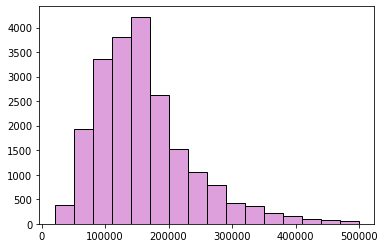

In [95]:
plt.hist(data[data['total_income']<500000]['total_income'], color = 'plum', edgecolor = 'black', bins='sturges') 
#значения больше 500000 не включены в график, так как их мало и они мешают наглядности распределения

Также псосмотрим на сухие числа:

In [96]:
data['total_income'].describe()

count    2.135200e+04
mean     1.653588e+05
std      9.829939e+04
min      2.066700e+04
25%      1.076482e+05
50%      1.425940e+05
75%      1.957835e+05
max      2.265604e+06
Name: total_income, dtype: float64

На основе этих данных было принято решение группировать заработок по перцентилям. Добавим столбец с категорией уровня заработка в таблицу.

In [97]:
# ПОСМОТРИМ ПРОСТО СТАТИСТИКИ

print(data.total_income.describe())

data['total_income_category'] = pd.qcut(data['total_income'], 4, labels=["низкий", "средний", "выше среднего", "высокий"])
print(data['total_income_category'].value_counts())

# ТЕПЕРЬ ПОСМОТРИМ РАСПРЕДЕЛЕНИЕ ДОХОДА ПО КАЖДОЙ КАТЕГОРИИ ДОХОДА

# я ввел огарничение в 600к, чтобы просто график был нагляднее и все

import plotly.express as px # просто импорт библиотеки для визуализации

fig = px.box(data.query('total_income < 600000'), x = 'total_income_category', y = 'total_income', title = 'Распределение дохода', template = 'plotly_dark')
fig.show()

count    2.135200e+04
mean     1.653588e+05
std      9.829939e+04
min      2.066700e+04
25%      1.076482e+05
50%      1.425940e+05
75%      1.957835e+05
max      2.265604e+06
Name: total_income, dtype: float64
средний          5452
высокий          5338
низкий           5338
выше среднего    5224
Name: total_income_category, dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



По графику и размаху усов каждого boxplot мы как раз можем наглядно проследить, как у нас прошло разбиение по квартилям, соотнося показатели с describe() Условно рассмотрим низкий доход, по ящику видим, что минимум там 20к, а максимум 107к, что соотносится с минимумом и 1 квартилем из describe()

In [98]:
q20 = data['total_income'].quantile(q=0.2)
q50 = data['total_income'].quantile(q=0.5)
q80 = data['total_income'].quantile(q=0.8)

def define_income_category(row):
    if row['total_income'] < q20:
        return '[0%%:20%%)'
    if q20 <= row['total_income'] < q50:
        return '[20%%:50%%)'
    if q50 <= row['total_income'] < q80:
        return '[50%%:80%%)'
    if row['total_income'] >= q80:
        return '[80%%:100%%]'

data['income_category'] = data.apply(define_income_category, axis=1)
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,total_income_category,income_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость,высокий,[80%%:100%%]
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,средний,[20%%:50%%)
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость,выше среднего,[50%%:80%%)
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,высокий,[80%%:100%%]
4,0,2316,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,выше среднего,[50%%:80%%)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21348,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,недвижимость,высокий,[80%%:100%%]
21349,0,2928,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,автомобиль,выше среднего,[50%%:80%%)
21350,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,недвижимость,низкий,[0%%:20%%)
21351,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,автомобиль,высокий,[80%%:100%%]


In [99]:
column = 'income_category'
statuses = data[column].drop_duplicates().to_list()
for status in statuses:
    ratio = calc_ratio(column, status)
    print('Процент людей, возвращающих кредит в срок, от числа людей в группе дохода "{}": {:.2%}'.format(status, ratio)) 

Процент людей, возвращающих кредит в срок, от числа людей в группе дохода "[80%%:100%%]": 93.00%
Процент людей, возвращающих кредит в срок, от числа людей в группе дохода "[20%%:50%%)": 91.47%
Процент людей, возвращающих кредит в срок, от числа людей в группе дохода "[50%%:80%%)": 91.49%
Процент людей, возвращающих кредит в срок, от числа людей в группе дохода "[0%%:20%%)": 91.97%


**Вывод**

Можно предположить, что люди, чей заработок выше, чем заработок 80% заёмщиков, менее склонны к задолженностям по кредиту. Как ни странно, люди, чей заработок ниже, чем заработок 20% заёмщиков, тоже показывают хороший процент возврата кредита вовремя.

In [100]:
import plotly.express as px

def pivot(data, index):
    
    pivot = data.pivot_table(index = index, values = 'debt', aggfunc = ['count', 'sum', 'mean']).reset_index()
    pivot.columns = [index, 'Кол-во клиентов', 'Кол-во должников', '% невозврата']
    display(pivot.sort_values('% невозврата', ascending = False))
    
    
    
    fig = px.bar(pivot, x = index, y = '% невозврата', color = '% невозврата', title = '% невозврата по ' + index)
    fig.show()
    

pivot(data, 'income_category')

,income_category,Кол-во клиентов,Кол-во должников,% невозврата
1,[20%%:50%%),5454,465,0.085259
2,[50%%:80%%),7356,626,0.085101
0,[0%%:20%%),4271,343,0.080309
3,[80%%:100%%],4271,299,0.070007


In [101]:
# можно пробежаться циклом по интересующим столбцам

features = ['children', 'family_status']

for col in features:
    
    pivot(data, col)

,children,Кол-во клиентов,Кол-во должников,% невозврата
4,4,41,4,0.097561
2,2,2114,202,0.095553
1,1,4839,442,0.091341
3,3,328,27,0.082317
0,0,14021,1058,0.075458
5,5,9,0,0.000000


,family_status,Кол-во клиентов,Кол-во должников,% невозврата
4,не женат / не замужем,2794,273,0.097709
2,гражданский брак,4129,386,0.093485
3,женат / замужем,12290,927,0.075427
0,в разводе,1185,85,0.071730
1,вдовец / вдова,954,62,0.064990


Добавили отдельно табличку и график по целям кредита:

In [102]:
pivot(data, 'purpose_category')

,purpose_category,Кол-во клиентов,Кол-во должников,% невозврата
0,автомобиль,4284,400,0.093371
2,образование,3995,370,0.092616
3,свадьба,2310,184,0.079654
1,недвижимость,10763,779,0.072378


<a id="summary"></a>
## Шаг 4. Общий вывод

На основе проведенного исследования можно сделать вывод, что наиболее ответственными заёмщиками можно считать бездетных людей, состоящих или когда-либо состоявших в браке, берущих кредит на недвижимость и имеющих высокий уровень заработка (выше, чем заработок 80% заёмщиков). 

<a id="check"></a>
## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.